In [1]:
import os
os.chdir('..')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import numpy as np
from notebooks import config
import geopandas as gpd
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
from utils.raster_vec import vec2mask
from matplotlib.colors import LinearSegmentedColormap


In [2]:
tibet_bounds = (73.50, 26.00, 104.42, 39.99)    # tibet

### Tibet sentinel-1 image check

In [277]:
labels_month = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', \
                'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']

path_tibet_shp =  config.root_proj + '/data/tibet/tibet-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp'
path_s1as_fp_202008 =  config.root_proj + '/data/tibet/s1_footprint/fp_months_as/fp_as_202008.gpkg'
path_s1des_fp_202008 =  config.root_proj + '/data/tibet/s1_footprint/fp_months_des/fp_des_202008.gpkg'


In [4]:
geodf_as_fp_202008 = gpd.read_file(path_s1as_fp_202008)
geodf_des_fp_202008 = gpd.read_file(path_s1des_fp_202008)
print('ascending image:', len(geodf_as_fp_202008))
print('descending image:', len(geodf_des_fp_202008))
geodf_as_fp_202008['geometry']


ascending image: 122
descending image: 115


0      POLYGON ((93.06079 26.98771, 93.05994 26.99036...
1      POLYGON ((90.35619 27.82848, 90.37578 27.69697...
2      POLYGON ((90.00280 29.61206, 89.98322 29.60875...
3      POLYGON ((90.73880 31.29049, 90.67613 31.28072...
4      POLYGON ((92.22632 31.51248, 92.22629 31.51678...
                             ...                        
117    POLYGON ((73.87521 36.99005, 73.89897 36.87271...
118    POLYGON ((73.77179 37.55171, 73.83426 37.56116...
119    POLYGON ((73.15970 40.57632, 73.11452 40.56978...
120    POLYGON ((97.18923 34.17601, 97.19520 34.15122...
121    POLYGON ((86.14241 37.38582, 86.16187 37.34352...
Name: geometry, Length: 122, dtype: geometry

### Footprint visualization

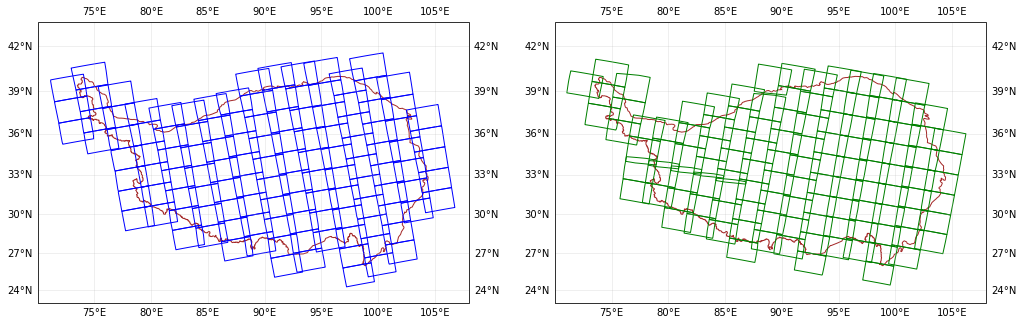

In [5]:
fig = plt.figure(figsize=(17, 6))
fea_tibet_shp = cfeature.ShapelyFeature(Reader(path_tibet_shp).geometries(), \
                            crs=ccrs.PlateCarree(), edgecolor='Brown', linewidth=1, facecolor='none')
fea_as_fp = cfeature.ShapelyFeature(Reader(path_s1as_fp_202008).geometries(), \
                            crs=ccrs.PlateCarree(), edgecolor='blue', linewidth=1, facecolor='none')
fea_des_fp = cfeature.ShapelyFeature(Reader(path_s1des_fp_202008).geometries(), \
                            crs=ccrs.PlateCarree(), edgecolor='green', linewidth=1, facecolor='none')

## 1. ascending footprint visualization
ax_1 = fig.add_subplot(1, 2, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax_1.set_extent([70, 108, 23.0, 42.0])
ax_1.add_feature(fea_tibet_shp, zorder=0) ## add tibet boundary
ax_1.add_feature(fea_as_fp, zorder=0)     ## add ascending footprint
ax_1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, zorder=1)

## 2. descending footprint visualization
ax_2 = fig.add_subplot(1, 2, 2, projection=ccrs.Mercator(central_longitude=88.5))
ax_2.set_extent([70, 108, 23.0, 42.0])
ax_2.add_feature(fea_tibet_shp, zorder=0)  ## add tibet boundary
ax_2.add_feature(fea_des_fp, zorder=0)     ## add descending footprint
ax_2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, zorder=1)


### Monthly data numbers mapping

In [6]:
ids = ['01','02','03','04','05','06','07','08','09','10','11','12']
path_base_img = config.root_proj + '/data/tibet/dem/tibet_SRTMGL3_900m.tif'
base_img, base_img_info = readTiff(path_base_img)
fp_as_months, fp_des_months = np.zeros_like(base_img), np.zeros_like(base_img)

for id in ids:
  ### ascending footprint
  path_s1as_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_as/fp_as_2020' + id + '.kml'
  path_mask_as_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_as/fp_as_mask_2020' + id + '.tif'
  fp_as_mask = vec2mask(path_vec=path_s1as_fp, \
                            path_raster=path_base_img, path_save = path_mask_as_fp)
  fp_as_months += fp_as_mask
  ### descending footprint
  path_s1des_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_des/fp_des_2020' + id + '.kml'
  path_mask_des_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_des/fp_des_mask_2020' + id + '.tif'
  fp_des_mask = vec2mask(path_vec=path_s1des_fp, \
                            path_raster=path_base_img, path_save=path_mask_des_fp)
  fp_des_months += fp_des_mask

fp_as_months_masked = np.ma.masked_equal(fp_as_months, 0)
fp_des_months_masked = np.ma.masked_equal(fp_des_months, 0)


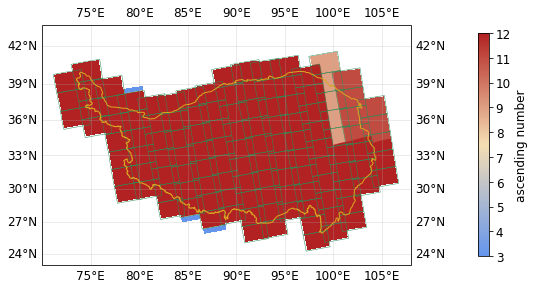

In [7]:
plt.rcParams.update({'font.size': 12})
cmap_num = LinearSegmentedColormap.from_list('linear color', ["CornflowerBlue", 'Wheat', "Firebrick"])
# cmap_num = LinearSegmentedColormap.from_list('linear color', ['Navy', "CornflowerBlue", 'Wheat', "Firebrick"])
fig = plt.figure(figsize=(8, 12))

### 1. ascending
ax_1 = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=89))
ax_1.set_extent([70, 108, 23.0, 42.0])
ax_as = ax_1.imshow(fp_as_months_masked, extent=base_img_info['geoextent'], 
                          vmin=3, vmax=12, cmap=cmap_num, transform=ccrs.PlateCarree(), zorder=0)  # cmap:PRGn
ax_1.add_feature(fea_as_fp, linewidth=0.5, edgecolor='SeaGreen', zorder=1)         ## add ascending footprint
ax_1.add_feature(fea_tibet_shp, edgecolor='Goldenrod', zorder=2)  ## add tibet boundary
ax_1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
plt.colorbar(ax_as, fraction=0.025, pad=0.15, label='ascending number')  #
# plt.savefig(config.root_proj + '/figure/s1as_num_map.png', bbox_inches='tight')

# ### 2. descending
# ax_2 = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=89))
# ax_2.set_extent([70, 108, 23.0, 42.0])
# ax_des = ax_2.imshow(fp_des_months_masked, extent=base_img_info['geoextent'], 
#                           vmin=3, vmax=12, cmap=cmap_num, transform=ccrs.PlateCarree(), zorder=0)  # cmap:PRGn
# ax_2.add_feature(fea_des_fp, linewidth=0.5, edgecolor='SeaGreen', zorder=1)         ## add ascending footprint
# ax_2.add_feature(fea_tibet_shp, edgecolor='Goldenrod', zorder=2)  ## add tibet boundary
# ax_2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
# # plt.colorbar(ax_des, fraction=0.025, pad=0.15, label='ascending number')  #
# # plt.savefig(config.root_proj + '/figure/s1des_num_map.png', bbox_inches='tight')


### Monthly data collection statics


In [239]:
ids = ['01','02','03','04','05','06','07','08','09','10','11','12']
s1as_dates = []
s1des_dates = []
for id in ids:
  ### ascending images
  path_s1as_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_as/fp_as_2020' + id + '.gpkg'
  geodf_s1as_fp = gpd.read_file(path_s1as_fp)
  imgs_id = list(geodf_s1as_fp['img_id'])
  imgs_dates = [img_id.split('/')[-1].split('_')[4][4:8] for img_id in imgs_id]
  s1as_dates += imgs_dates
  ### descending images
  path_s1des_fp =  config.root_proj + '/data/tibet/s1_footprint/fp_months_des/fp_des_2020' + id + '.gpkg'
  geodf_s1des_fp = gpd.read_file(path_s1des_fp)
  imgs_id = list(geodf_s1des_fp['img_id'])
  imgs_dates = [img_id.split('/')[-1].split('_')[4][4:8] for img_id in imgs_id]
  s1des_dates += imgs_dates

print('number of ascending images:', len(s1as_dates))
print('number of descending images:', len(s1des_dates))
### convert date to np.array()
s1as_dates_month = [int(s1as_date[0:2]) for s1as_date in s1as_dates]
s1as_dates_day = [int(s1as_date[2:4]) for s1as_date in s1as_dates]
s1as_dates_arr = np.array([s1as_dates_month,s1as_dates_day])
s1des_dates_month = [int(s1des_date[0:2]) for s1des_date in s1des_dates]
s1des_dates_day = [int(s1des_date[2:4]) for s1des_date in s1des_dates]
s1des_dates_arr = np.array([s1des_dates_month, s1des_dates_day])
### statics
s1as_months_hist, _ = np.histogram(a=s1as_dates_arr[0], bins=np.arange(13)+1)
s1des_months_hist, _ = np.histogram(a=s1des_dates_arr[0], bins=np.arange(13)+1) 
s1as_days_hist, _ = np.histogram(a=s1as_dates_arr[1], bins=np.arange(32)+1) 
s1des_days_hist, _ = np.histogram(a=s1des_dates_arr[1], bins=np.arange(32)+1) 
print('Months bins:', len(s1as_months_hist))
print('Days bins:', len(s1as_days_hist))


number of ascending images: 1449
number of descending images: 1315
Months bins: 12
Days bins: 31


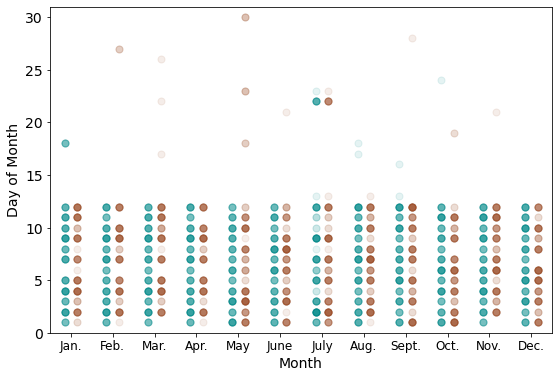

In [303]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(9, 6))
width = 0.4
plt.scatter(x=s1as_dates_arr[0]-0.15, y=s1as_dates_arr[1], s=50, c='DarkCyan', alpha=0.1)
plt.scatter(x=s1des_dates_arr[0]+0.15, y=s1des_dates_arr[1], s=50, c='Sienna', alpha=0.1)

plt.xticks(np.arange(12)+1, labels_month, fontsize=12, rotation=0);
plt.ylim([0, 31])
plt.xlim([0.5, 12.5])
plt.xlabel('Month', fontsize=14)
plt.ylabel('Day of Month', fontsize=14)
plt.savefig(config.root_proj + '/figure/s1_stat.png', bbox_inches='tight')


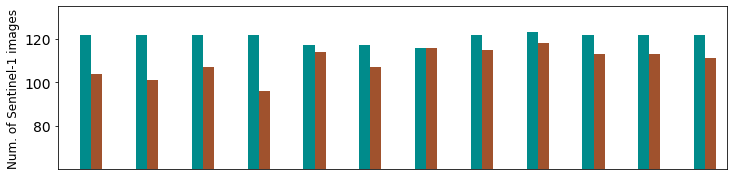

In [310]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12,3))
width = 0.2

ax.bar(np.arange(12)+1, s1as_months_hist, width=width, color='DarkCyan', label = "Ascending images");
ax.bar(np.arange(12)+1+width, s1des_months_hist, width=width, color='Sienna', label = "Descending images");

plt.xticks(np.arange(12)+1 + width / 2, labels_month, fontsize=10, rotation=0);
plt.ylim([60.1, 135])
plt.xlim([0.5, 12.5])
# plt.xlabel('Month', fontsize=14)
ax.set_xticks([])
plt.ylabel('Num. of Sentinel-1 images', fontsize=12)
# plt.legend(loc='upper center', ncol=2, fontsize=12, frameon=True, edgecolor='black')
# plt.savefig(config.root_proj + '/figure/s1_stat_month.png', bbox_inches='tight')


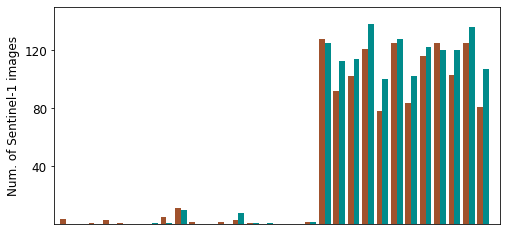

In [317]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8,4))
# labels_day = [i+1 for i in range(31)]
width = 0.4

ax.bar(np.arange(31)+1, s1as_days_hist, width=width, color='DarkCyan', label = "Ascending images");
ax.bar(np.arange(31)+1+width, s1des_days_hist, width=width, color='Sienna', label = "Descending images");

y_ticks = np.arange(0, 140, 40)
plt.yticks(y_ticks,fontsize=12)
# plt.xticks(np.arange(31) + width / 2, labels_day[::-1], fontsize=10, rotation=0);
plt.ylim([0.1, 150])
plt.xlim(31, 0)
# plt.xlabel('Day of month', fontsize=12)
ax.set_xticks([])
plt.ylabel('Num. of Sentinel-1 images', fontsize=12)
# plt.legend(loc='upper left', ncol=2, fontsize=12, frameon=True, edgecolor='black')
plt.savefig(config.root_proj + '/figure/s1_stat_day.png', bbox_inches='tight')
